In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import pandas as pd
from pandas.plotting import scatter_matrix
from pyspark.sql.functions import corr
import seaborn as sns

In [ ]:
spark = SparkSession.builder.appName("RegresionLineal").getOrCreate()

data = spark.read.csv("sms_spam.csv", header=True, inferSchema=True)
data.printSchema()

root
 |-- type: string (nullable = true)
 |-- text: string (nullable = true)



In [ ]:
columnas_string = [col_name for col_name, data_type in data.dtypes if data_type == 'string']
data.select(columnas_string).show()

+----+--------------------+
|type|                text|
+----+--------------------+
| ham|Go until jurong p...|
| ham|Ok lar... Joking ...|
|spam|Free entry in 2 a...|
| ham|U dun say so earl...|
| ham|Nah I don't think...|
|spam|FreeMsg Hey there...|
| ham|Even my brother i...|
| ham|As per your reque...|
|spam|WINNER!! As a val...|
|spam|Had your mobile 1...|
| ham|I'm gonna be home...|
|spam|SIX chances to wi...|
|spam|URGENT! You have ...|
| ham|I've been searchi...|
| ham|I HAVE A DATE ON ...|
|spam|XXXMobileMovieClu...|
| ham|Oh k...i'm watchi...|
| ham|Eh u remember how...|
| ham|Fine if that's th...|
|spam|England v Macedon...|
+----+--------------------+
only showing top 20 rows



In [ ]:
sms_corpus_pandas = data.toPandas()
print(sms_corpus_pandas)

      type                                               text
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...
...    ...                                                ...
5569  spam  This is the 2nd time we have tried 2 contact u...
5570   ham               Will ü b going to esplanade fr home?
5571   ham  Pity, * was in mood for that. So...any other s...
5572   ham  The guy did some bitching but I acted like i'd...
5573   ham                         Rofl. Its true to its name

[5574 rows x 2 columns]


In [ ]:
sms_corpus_subset = data.limit(2).collect()
sms_corpus_subset_list = [row.asDict() for row in sms_corpus_subset]

for row in sms_corpus_subset_list:
	print(row)

{'type': 'ham', 'text': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'}
{'type': 'ham', 'text': 'Ok lar... Joking wif u oni...'}


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.ml import Pipeline

spark = SparkSession.builder.appName("CreacionCorpus").getOrCreate()

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
count_vectorizer = CountVectorizer(inputCol="tokens", outputCol="features")
pipeline = Pipeline(stages=[tokenizer, count_vectorizer])
sms_corpus = pipeline.fit(data).transform(data)

sms_corpus.show()

+----+--------------------+--------------------+--------------------+
|type|                text|              tokens|            features|
+----+--------------------+--------------------+--------------------+
| ham|Go until jurong p...|[go, until, juron...|(13525,[8,42,51,6...|
| ham|Ok lar... Joking ...|[ok, lar..., joki...|(13525,[5,74,407,...|
|spam|Free entry in 2 a...|[free, entry, in,...|(13525,[0,3,8,20,...|
| ham|U dun say so earl...|[u, dun, say, so,...|(13525,[5,22,60,1...|
| ham|Nah I don't think...|[nah, i, don't, t...|(13525,[0,1,66,86...|
|spam|FreeMsg Hey there...|[freemsg, hey, th...|(13525,[0,2,6,10,...|
| ham|Even my brother i...|[even, my, brothe...|(13525,[0,7,9,13,...|
| ham|As per your reque...|[as, per, your, r...|(13525,[0,10,11,4...|
|spam|WINNER!! As a val...|[winner!!, as, a,...|(13525,[0,2,3,14,...|
|spam|Had your mobile 1...|[had, your, mobil...|(13525,[0,4,5,10,...|
| ham|I'm gonna be home...|[i'm, gonna, be, ...|(13525,[0,1,6,28,...|
|spam|SIX chances to

In [ ]:
numero_documentos = sms_corpus.count()
print("Número de documentos:", numero_documentos)

Número de documentos: 5574


In [ ]:
documentos = data.select("text").limit(2).collect()

for i, documento in enumerate(documentos):
	print(f"Documento {i + 1}:")
	print("Metadata:", len(documento[0]))
	print("Content: chars:", len(documento[0]))
	print()

Documento 1:
Metadata: 111
Content: chars: 111

Documento 2:
Metadata: 29
Content: chars: 29



In [ ]:
documento_str = str(documentos)
print(documento_str, "")

[Row(text='Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'), Row(text='Ok lar... Joking wif u oni...')] 


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower

sms_corpus_clean = sms_corpus.withColumn("text", lower(sms_corpus["text"]))
sms_corpus_clean.show()

+----+--------------------+--------------------+--------------------+
|type|                text|              tokens|            features|
+----+--------------------+--------------------+--------------------+
| ham|go until jurong p...|[go, until, juron...|(13525,[8,42,51,6...|
| ham|ok lar... joking ...|[ok, lar..., joki...|(13525,[5,74,407,...|
|spam|free entry in 2 a...|[free, entry, in,...|(13525,[0,3,8,20,...|
| ham|u dun say so earl...|[u, dun, say, so,...|(13525,[5,22,60,1...|
| ham|nah i don't think...|[nah, i, don't, t...|(13525,[0,1,66,86...|
|spam|freemsg hey there...|[freemsg, hey, th...|(13525,[0,2,6,10,...|
| ham|even my brother i...|[even, my, brothe...|(13525,[0,7,9,13,...|
| ham|as per your reque...|[as, per, your, r...|(13525,[0,10,11,4...|
|spam|winner!! as a val...|[winner!!, as, a,...|(13525,[0,2,3,14,...|
|spam|had your mobile 1...|[had, your, mobil...|(13525,[0,4,5,10,...|
| ham|i'm gonna be home...|[i'm, gonna, be, ...|(13525,[0,1,6,28,...|
|spam|six chances to

In [ ]:
from pyspark.sql.functions import lower, col

stop_words = [".",",", "!", "‘", "'"]

sms_corpus_clean = sms_corpus.withColumn("text", lower(col("text")))

for word in stop_words:
	sms_corpus_clean = sms_corpus_clean.filter(~(col("text").contains(word)))

sms_corpus_clean.show()

+----+--------------------+--------------------+--------------------+
|type|                text|              tokens|            features|
+----+--------------------+--------------------+--------------------+
| ham|is that seriously...|[is, that, seriou...|(13525,[2,7,18,46...|
| ham|for fear of faint...|[for, fear, of, f...|(13525,[2,3,4,10,...|
| ham|i see the letter ...|[i, see, the, let...|(13525,[1,4,9,16,...|
| ham| who are you seeing?|[who, are, you, s...|(13525,[2,17,110,...|
| ham|do you know what ...|[do, you, know, w...|(13525,[2,21,36,4...|
| ham|tell where you re...|[tell, where, you...|(13525,[2,90,119,...|
| ham|its a part of che...|[its, a, part, of...|(13525,[3,12,59,4...|
| ham|hi babe im at hom...|[hi, babe, im, at...|(13525,[26,36,49,...|
| ham|does not operate ...|[does, not, opera...|(13525,[21,24,25,...|
| ham|ok i am on the wa...|[ok, i, am, on, t...|(13525,[0,1,4,16,...|
| ham|you will be in th...|[you, will, be, i...|(13525,[2,4,8,12,...|
| ham|i see a cup of

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, regexp_replace, col

spark = SparkSession.builder.appName("EjemploPySpark").getOrCreate()

def replace_punctuation(text_col):
    return regexp_replace(text_col, r'[!\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', ' ')

sms_corpus_clean = sms_corpus.withColumn("text", lower(col("text")))
sms_corpus_clean = sms_corpus_clean.withColumn("text", replace_punctuation(col("text")))

sms_corpus_clean.show()

+----+--------------------+--------------------+--------------------+
|type|                text|              tokens|            features|
+----+--------------------+--------------------+--------------------+
| ham|go until jurong p...|[go, until, juron...|(13525,[8,42,51,6...|
| ham|ok lar    joking ...|[ok, lar..., joki...|(13525,[5,74,407,...|
|spam|free entry in 2 a...|[free, entry, in,...|(13525,[0,3,8,20,...|
| ham|u dun say so earl...|[u, dun, say, so,...|(13525,[5,22,60,1...|
| ham|nah i don t think...|[nah, i, don't, t...|(13525,[0,1,66,86...|
|spam|freemsg hey there...|[freemsg, hey, th...|(13525,[0,2,6,10,...|
| ham|even my brother i...|[even, my, brothe...|(13525,[0,7,9,13,...|
| ham|as per your reque...|[as, per, your, r...|(13525,[0,10,11,4...|
|spam|winner   as a val...|[winner!!, as, a,...|(13525,[0,2,3,14,...|
|spam|had your mobile 1...|[had, your, mobil...|(13525,[0,4,5,10,...|
| ham|i m gonna be home...|[i'm, gonna, be, ...|(13525,[0,1,6,28,...|
|spam|six chances to

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
from nltk.stem import PorterStemmer

words = ["learn", "learned", "learning", "learns"]

nltk.download('punkt')
stemmer = PorterStemmer()

def stem_words(word_list):
	return [stemmer.stem(word) for word in word_list]

word_df = spark.createDataFrame([(words,)], ["words"])
stem_udf = udf(stem_words, StringType())
result_df = word_df.withColumn("stemmed_words", stem_udf("words"))

result_df.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


+--------------------+--------------------+
|               words|       stemmed_words|
+--------------------+--------------------+
|[learn, learned, ...|[learn, learn, le...|
+--------------------+--------------------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
from nltk.stem import PorterStemmer

nltk.download('punkt')
stemmer = PorterStemmer()

def stem_text(text):
	words = text.split()
	stemmed_words = [stemmer.stem(word) for word in words]
	return ' '.join(stemmed_words)

stem_udf = udf(stem_text, StringType())

sms_corpus_clean = sms_corpus_clean.withColumn("text", stem_udf("text"))

sms_corpus_clean.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


+----+--------------------+--------------------+--------------------+
|type|                text|              tokens|            features|
+----+--------------------+--------------------+--------------------+
| ham|go until jurong p...|[go, until, juron...|(13525,[8,42,51,6...|
| ham|ok lar joke wif u...|[ok, lar..., joki...|(13525,[5,74,407,...|
|spam|free entri in 2 a...|[free, entry, in,...|(13525,[0,3,8,20,...|
| ham|u dun say so earl...|[u, dun, say, so,...|(13525,[5,22,60,1...|
| ham|nah i don t think...|[nah, i, don't, t...|(13525,[0,1,66,86...|
|spam|freemsg hey there...|[freemsg, hey, th...|(13525,[0,2,6,10,...|
| ham|even my brother i...|[even, my, brothe...|(13525,[0,7,9,13,...|
| ham|as per your reque...|[as, per, your, r...|(13525,[0,10,11,4...|
|spam|winner as a valu ...|[winner!!, as, a,...|(13525,[0,2,3,14,...|
|spam|had your mobil 11...|[had, your, mobil...|(13525,[0,4,5,10,...|
| ham|i m gonna be home...|[i'm, gonna, be, ...|(13525,[0,1,6,28,...|
|spam|six chanc to w

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace

sms_corpus_clean = sms_corpus_clean.withColumn("text", regexp_replace("text", r'\s+', ' '))

sms_corpus_clean.show()

+----+--------------------+--------------------+--------------------+
|type|                text|              tokens|            features|
+----+--------------------+--------------------+--------------------+
| ham|go until jurong p...|[go, until, juron...|(13525,[8,42,51,6...|
| ham|ok lar joke wif u...|[ok, lar..., joki...|(13525,[5,74,407,...|
|spam|free entri in 2 a...|[free, entry, in,...|(13525,[0,3,8,20,...|
| ham|u dun say so earl...|[u, dun, say, so,...|(13525,[5,22,60,1...|
| ham|nah i don t think...|[nah, i, don't, t...|(13525,[0,1,66,86...|
|spam|freemsg hey there...|[freemsg, hey, th...|(13525,[0,2,6,10,...|
| ham|even my brother i...|[even, my, brothe...|(13525,[0,7,9,13,...|
| ham|as per your reque...|[as, per, your, r...|(13525,[0,10,11,4...|
|spam|winner as a valu ...|[winner!!, as, a,...|(13525,[0,2,3,14,...|
|spam|had your mobil 11...|[had, your, mobil...|(13525,[0,4,5,10,...|
| ham|i m gonna be home...|[i'm, gonna, be, ...|(13525,[0,1,6,28,...|
|spam|six chanc to w

In [ ]:
train_ratio = 0.7
test_ratio = 1.0 - train_ratio
sms_dtm_train, sms_dtm_test = sms_corpus_clean.randomSplit([train_ratio, test_ratio], seed=42)

print("Número de filas en el conjunto de entrenamiento:", sms_dtm_train.count())
print("Número de filas en el conjunto de prueba:", sms_dtm_test.count())

Número de filas en el conjunto de entrenamiento: 3981
Número de filas en el conjunto de prueba: 1593


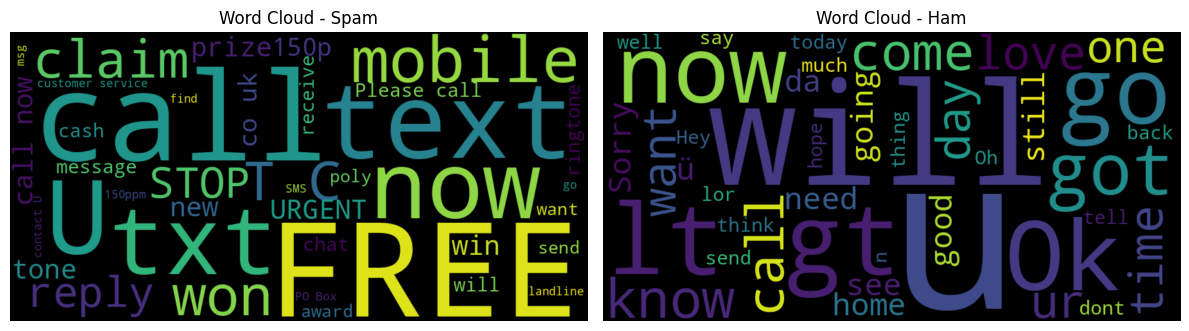

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyspark.sql.functions as F

spam_data = data.filter(data['type'] == 'spam')

ham_data = data.filter(data['type'] == 'ham')

spam_data = spam_data.withColumn("text", F.col("text").cast("string"))
ham_data = ham_data.withColumn("text", F.col("text").cast("string"))

spam_text = " ".join(spam_data.select("text").rdd.flatMap(lambda x: x).collect())
ham_text = " ".join(ham_data.select("text").rdd.flatMap(lambda x: x).collect())

wordcloud_spam = WordCloud(max_words=40, width=300, height=150, scale=3.0).generate(spam_text)
wordcloud_ham = WordCloud(max_words=40, width=300, height=150, scale=3.0).generate(ham_text)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_spam, interpolation="bilinear")
plt.title("Word Cloud - Spam")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ham, interpolation="bilinear")
plt.title("Word Cloud - Ham")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="rawFeatures")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="idf_features")
indexer = StringIndexer(inputCol="type", outputCol="label")
nb = NaiveBayes(labelCol="label", featuresCol="idf_features")
pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, indexer, nb])
model = pipeline.fit(sms_dtm_train)

predictions = model.transform(sms_dtm_test)

evaluator = MulticlassClassificationEvaluator(
	labelCol="label",
	predictionCol="prediction",
	metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print("Accuracy en el conjunto de prueba:", accuracy)
print(model)

Accuracy en el conjunto de prueba: 0.9780288763339611
PipelineModel_2324f1c6d5f5


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr

data_with_predictions = data.join(predictions, on="type")
crosstab = data_with_predictions.crosstab("type", "prediction")
crosstab.show()

crosstab_percentage = crosstab.withColumn("ham_percentage", expr("ham / (ham + spam)"))
crosstab_percentage = crosstab_percentage.withColumn("spam_percentage", expr("spam / (ham + spam)"))
crosstab_percentage.show()

+---------------+-------+------+
|type_prediction|    0.0|   1.0|
+---------------+-------+------+
|            ham|6641952| 24135|
|           spam|  22410|135954|
+---------------+-------+------+



AnalysisException: ignored